In [88]:
%matplotlib inline
from matplotlib import style
import matplotlib.pyplot as plt
from importlib import reload
import pandas as pd
import datetime as dt
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func , desc

In [89]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite",echo=False)
conn = engine.connect()

# Reflect Tables into SQLAlchemy ORM

In [90]:
#Explore Database
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [91]:
# Get a list of column names and types measurement
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [92]:
# Get a list of column names and types station
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [93]:
engine.execute('SELECT * FROM measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [94]:
engine.execute('SELECT * FROM station LIMIT 5').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

In [95]:
# reflect an existing database into a new model
# reflect the tables 
Base = automap_base()
Base.prepare(autoload_with=engine)
Base.classes.keys()

['measurement', 'station']

In [96]:
# View all of the classes that automap found
Measurement = Base.classes.measurement
Station = Base.classes.station

In [97]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [98]:
# Find the most recent date in the data set.
latest_date = session.query(Measurement.date).\
              order_by(Measurement.date.desc()).first()[0]
latest_date

'2017-08-23'

In [99]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
year_ago = dt.datetime.strptime(latest_date, '%Y-%m-%d') \
            - dt.timedelta(days=365)
year_ago

datetime.datetime(2016, 8, 23, 0, 0)

In [100]:
# Perform a query to retrieve the date and precipitation scores
query=session.query(Measurement.date,func.avg(Measurement.prcp)).\
        filter(Measurement.date >= year_ago).\
        group_by(Measurement.date).all()
#query

In [101]:
 # Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(query, columns=['date','prcp'])
df.set_index('date', inplace=True)
df

,prcp
date,
2016-08-24,1.555000
2016-08-25,0.077143
2016-08-26,0.016667
2016-08-27,0.064000
2016-08-28,0.516667
...,...
2017-08-19,0.030000
2017-08-20,0.005000
2017-08-21,0.193333


In [102]:
# # Sort the dataframe by date
df.sort_values(by='date', inplace=True)
#df

<function matplotlib.pyplot.show(close=None, block=None)>

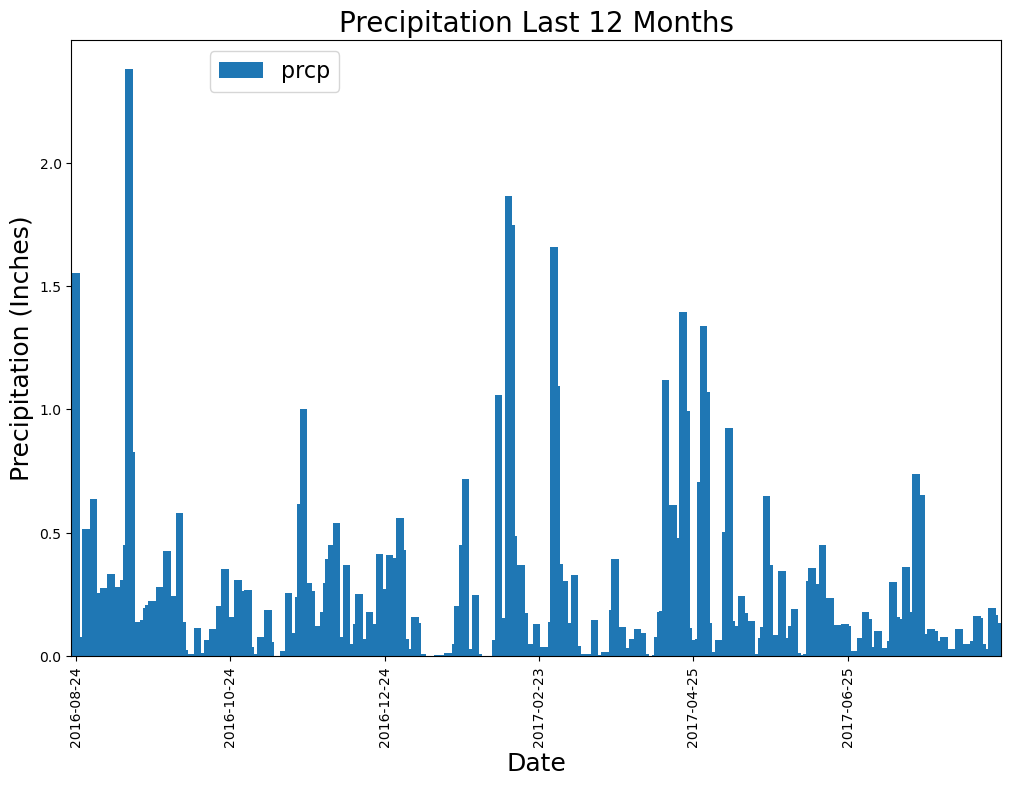

In [103]:
# # Use Pandas Plotting with Matplotlib to plot the data
ax = df.plot(kind='bar', width=3, figsize=(12,8))
plt.locator_params(axis='x', nbins=6)
# ax.xaxis.set_major_formatter(plt.NullFormatter())
# ax.tick_params(axis='y', labelsize=16)
# ax.grid(True)
plt.legend(bbox_to_anchor=(.3,1), fontsize="16")
plt.title("Precipitation Last 12 Months", size=20)
plt.ylabel("Precipitation (Inches)", size=18)
plt.xlabel("Date", size=18)
plt.show

In [104]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,prcp
count,365.000000
mean,0.169987
std,0.295722
min,0.000000
25%,0.008571
50%,0.070000
75%,0.191667
max,2.380000


# Exploratory Station Analysis

In [105]:
# Design a query to calculate the total number stations in the dataset
stations = session.query(Station)
for sta in stations:
    print(f'{sta.station}')
totalStations = session.query(func.count(Station.station)).first()[0]
totalStations

USC00519397
USC00513117
USC00514830
USC00517948
USC00518838
USC00519523
USC00519281
USC00511918
USC00516128


9

In [106]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
active_station=session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()
active_station

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [110]:
#find the most active station
most_active = active_station[0][0]
most_active

'USC00519281'

In [111]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
session.query(Measurement.station, func.max(Measurement.tobs), func.min(Measurement.tobs), func.avg(Measurement.tobs)).\
        filter(Measurement.station == most_active).all()

[('USC00519281', 85.0, 54.0, 71.66378066378067)]

In [112]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
res = session.query( Measurement.tobs).\
        filter(Measurement.station == most_active).\
        filter(Measurement.date >= year_ago).all()

In [113]:
# Query the last 12 months of temperature observation data 
tobs_df = pd.DataFrame(res, columns=['tobs'])
tobs_df 

,tobs
0,77.0
1,80.0
2,80.0
3,75.0
4,73.0
...,...
346,77.0
347,77.0
348,76.0
349,76.0


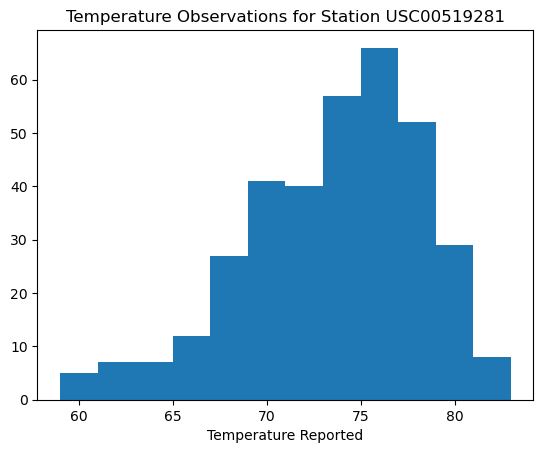

In [114]:
#for most active station and plot the results as a histogram
plt.hist(tobs_df,bins= 12)
plt.title("Temperature Observations for Station " + most_active)
plt.xlabel("Temperature Reported")
plt.show()

In [115]:
# Write a function called calc_temps that will accept a start date and end date in the format %Y-%m-%d 
# and return the minimum, average, and maximum temperatures for that range of dates.
def calc_temps(start_date, end_date):
    c_results = session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
                    filter(Measurement.date >= start_date).\
                    filter(Measurement.date <= end_date).all()
    return c_results
calc_temps('2016-08-23', '2017-08-23')

[(58.0, 74.59058295964125, 87.0)]

In [116]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_results = calc_temps('2016-08-23', '2016-08-24')
trip_results

[(74.0, 77.92857142857143, 81.0)]

# Close session

In [117]:
# Close Session
session.close()